In [85]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
from scipy.optimize import minimize

import matplotlib
matplotlib.rc('xtick', labelsize=16) 
matplotlib.rc('ytick', labelsize=16)


### a)

In [86]:
df = pd.read_excel("sv.xlsx")
df.head()

,GBPUSD
0,-0.355532
1,1.425409
2,-0.443940
3,1.025650
4,1.677579


In [87]:
df['returns'] = np.exp(df['GBPUSD']/100) - 1
print(df['returns'].describe())
df

count    945.000000
mean      -0.000328
std        0.007124
min       -0.032424
25%       -0.004384
50%       -0.000457
75%        0.003651
max        0.046389
Name: returns, dtype: float64


,GBPUSD,returns
0,-0.355532,-0.003549
1,1.425409,0.014356
2,-0.443940,-0.004430
3,1.025650,0.010309
4,1.677579,0.016917
...,...,...
940,0.428767,0.004297
941,-0.093392,-0.000933
942,0.891444,0.008954
943,-0.945963,-0.009415


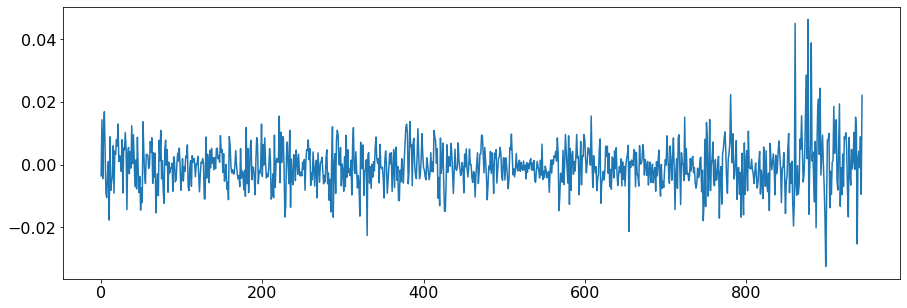

In [88]:
plt.plot(df['returns'])
plt.show()


### b)

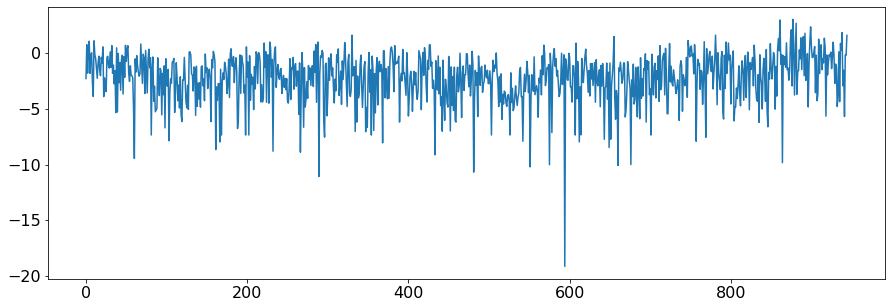

In [89]:
df['xt'] = np.log((df['GBPUSD'] - df['GBPUSD'].mean())**2)
plt.plot(df['xt'])
plt.show()

### c)

In [90]:

# Define the linearized model parameters
phi = 0.995
omega = (1 - phi) * (df['xt'].mean() + 1.27)
sigma_eta = (1 - phi) * (np.var(df['xt']) - np.pi**2/2)

# Define the initial state variables and their covariance
a0 = omega / (1 - phi)
P0 = sigma_eta / (1 - phi**2)

# Define the observation matrix and covariance
H = np.pi**2/2

# Define the likelihood function
def likelihood(params, a0, P0, y, H):
    omega, phi, sigma_eta = params
    n_obs = y.shape[0]
    loglik = 0
    a = a0
    P = P0
    d = -1.27
    c = omega
    T = phi
    Q = sigma_eta
    for t in range(n_obs):
        v = y[t] - a - d
        F = P + H
        K = T * P * F**-1

        a = T * a + K * v + c
        P = T**2 * P  + Q -  F * K**2

        # Compute the log-likelihood contribution for this time step
        loglik += -0.5 * (np.log(2 * np.pi) + np.log(F) + v**2 / F)

    return -loglik

params0 = [omega, phi, sigma_eta]
bounds = ((None, None), (0, 1), (0, None))
res = minimize(fun=likelihood, x0=params0, args=(a0, P0, df['xt'], H), bounds=bounds, options={'maxiter':5000})
  
omega_hat, phi_hat, sigma_eta_hat = res.x


### d)

In [91]:
def kalman_filter(params, y):
    omega, phi, sigma_eta = params
    n_obs = y.shape[0]
    a0 = omega / (1 - phi)
    P0 = sigma_eta / (1 - phi**2) 
    a = a0
    P = P0
    d = -1.27
    c = omega
    T = phi
    Q = sigma_eta
    H = np.pi**2/2

    df_kf = pd.DataFrame(columns=['a_filter', 'P', 'v', 'F', 'K'])

    for t in range(n_obs):
        v = y[t] - a - d
        F = P + H
        K = T * P * F**-1

        df_kf.loc[t] = [a, P, v, F, K]

        a = T * a + K * v + c
        P = T**2 * P  + Q -  F * K**2
      
    uncon_mean = params[0] / (1 - params[1])
    df_kf['h_filter'] = df_kf['a_filter'] - uncon_mean

    return df_kf

df_kf = kalman_filter(res.x, df['xt'])
df_kf

,a_filter,P,v,F,K,h_filter
0,-0.904153,0.375374,-0.103332,5.310176,0.069988,0.000000
1,-0.911385,0.349363,2.939243,5.284165,0.065459,-0.007232
2,-0.718914,0.327235,0.199022,5.262037,0.061571,0.185239
3,-0.708499,0.308238,2.096848,5.243040,0.058206,0.195654
4,-0.588391,0.291800,2.934754,5.226603,0.055276,0.315762
...,...,...,...,...,...,...
940,-0.033775,0.151484,-0.231634,5.086286,0.029487,0.870379
941,-0.049244,0.151484,-4.372547,5.086286,0.029487,0.854909
942,-0.186664,0.151484,1.304531,5.086286,0.029487,0.717490
943,-0.155319,0.151484,1.238132,5.086286,0.029487,0.748835


In [92]:
def kalman_smoother(params, y):
    df_kf = kalman_filter(params, df['xt'])
    df_kf = df_kf.iloc[::-1].reset_index(drop=True)
    df_ks = pd.DataFrame(columns=['r', 'a_smoother', 'N', 'V'])
    n_obs = y.shape[0]
    r = 0
    N = 0

    for t in range(n_obs):
        
        r = df_kf['F'][t]**-1 * df_kf['v'][t] + (1-df_kf['K'][t])*r
        N = df_kf['F'][t]**-1 + (1-df_kf['K'][t])**2 * N

        a = df_kf['a_filter'][t] + df_kf['P'][t]*r
        V = df_kf['P'][t] - df_kf['P'][t]**2 * N

        df_ks.loc[t] = [r, a, N, V]

    df_ks = df_ks.iloc[::-1].reset_index(drop=True)
    uncon_mean = params[0] / (1 - params[1])
    df_ks['h_smoother'] = df_ks['a_smoother'] - uncon_mean
    return df_ks    

df_ks = kalman_smoother(res.x, df['xt'])
df_ks


,r,a_smoother,N,V,h_smoother
0,1.812200,-0.223901,2.037044,0.088343,0.680252
1,1.969501,-0.223315,2.137447,0.088478,0.680838
2,1.512255,-0.224052,2.230680,0.088368,0.680102
3,1.571170,-0.224205,2.317198,0.088080,0.679948
4,1.243628,-0.225500,2.397438,0.087665,0.678653
...,...,...,...,...,...
940,0.106561,-0.017633,0.875244,0.131399,0.886521
941,0.156723,-0.025503,0.720502,0.134950,0.878650
942,1.047278,-0.028018,0.556214,0.138720,0.876135
943,0.814825,-0.031886,0.381790,0.142723,0.872268


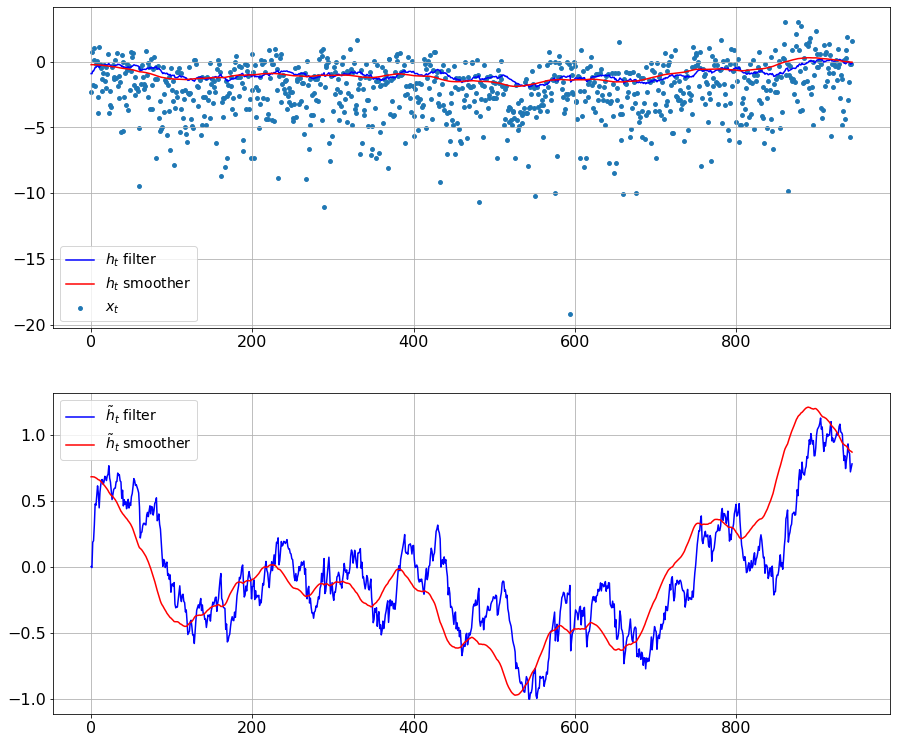

In [103]:
fig, axs = plt.subplots(2,1, figsize=(15,13))

# upper left
ax = axs[0]

ax.scatter(df.index, df.xt, s=15, label = r'$x_t$')
ax.plot(df.index, df_kf.a_filter, color = 'b', label = r'$h_t$ filter')
ax.plot(df.index, df_ks.a_smoother, color = 'r', label = r"$h_t$ smoother")
ax.legend(fontsize = 14)

ax = axs[1]
ax.plot(df.index, df_kf.h_filter, color = 'b', label = r"$\tilde{h}_t$ filter")
ax.plot(df.index, df_ks.h_smoother, color = 'r', label = r"$\tilde{h}_t$ smoother" )
ax.legend(fontsize = 14)

for ax in axs:
    ax.grid()
    pass

plt.show()

### e)

In [105]:
import yfinance as yf

# Define the ticker symbol for S&P 500 index
tickerSymbol = '^GSPC'

# Set the start and end dates for the data
startDate = '2015-01-01'
endDate = '2022-03-11'

# Get the data for S&P 500 index
sp500 = yf.Ticker(tickerSymbol)

# Get the historical data for the selected dates
sp500Data = sp500.history(start=startDate, end=endDate)

# Calculate the daily returns
sp500Returns = sp500Data['Close'].pct_change()

# Print the first 10 rows of the returns
print(sp500Returns.head(10))

Date
2020-01-02 00:00:00-05:00         NaN
2020-01-03 00:00:00-05:00   -0.007060
2020-01-06 00:00:00-05:00    0.003533
2020-01-07 00:00:00-05:00   -0.002803
2020-01-08 00:00:00-05:00    0.004902
2020-01-09 00:00:00-05:00    0.006655
2020-01-10 00:00:00-05:00   -0.002855
2020-01-13 00:00:00-05:00    0.006976
2020-01-14 00:00:00-05:00   -0.001515
2020-01-15 00:00:00-05:00    0.001870
Name: Close, dtype: float64


In [106]:
# Define the tickers for S&P500 and Apple
tickers = ['^GSPC']

# Define the start and end dates for the data
start_date = '2016-03-11'
end_date = '2023-03-11'

# Retrieve the historical data for the tickers from Yahoo Finance
data = yf.download(tickers, start=start_date, end=end_date)

# Extract the adjusted close prices for the tickers
adj_close = data['Adj Close']

# Calculate the daily returns for the tickers
daily_returns = adj_close.pct_change()

# Print the daily returns for the tickers
print(daily_returns.tail())

Exception in thread Thread-5:
Traceback (most recent call last):
  File "c:\Users\meesp\Anaconda3\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "c:\Users\meesp\Anaconda3\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "c:\Users\meesp\Anaconda3\lib\site-packages\multitasking\__init__.py", line 104, in _run_via_pool
    return callee(*args, **kwargs)
  File "c:\Users\meesp\Anaconda3\lib\site-packages\yfinance\multi.py", line 201, in _download_one_threaded
    keepna, timeout, many=True)
  File "c:\Users\meesp\Anaconda3\lib\site-packages\yfinance\multi.py", line 218, in _download_one
    many=many)
  File "c:\Users\meesp\Anaconda3\lib\site-packages\yfinance\base.py", line 156, in history
    tz = self._get_ticker_tz(debug_mode, proxy, timeout)
  File "c:\Users\meesp\Anaconda3\lib\site-packages\yfinance\base.py", line 339, in _get_ticker_tz
    tkr_tz = utils.cache_lookup_tkr_tz(self.ticker)
  File "c:\Users\meesp\Anaconda3\

KeyboardInterrupt: 

In [ ]:
df = pd.DataFrame(daily_returns)
df

### f)